In [1]:
import torch
from torch.utils import data
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

import cv2

import csv

from progressbar import *               # just a simple progress bar

In [2]:
import my2_classes # With that way we import the my_classes code inside and we 
# have the ability to run my_classes.customDatasetVideos in the next block

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # set up the GPU

## Creating the model of the Neural network

The size of the new layer $$H_{new} = \frac{H_{old}+2*Padding_H-Kernel_H}{Stride_H}+1$$ 

most of the time is just $H_{new} = H_{old}-Kernel_H+1$ becuase we don't have Padding and stride

Lets $H=150$ this means that $H_{new} = 150-5+1$ and all that needs to be devided by two becasue we have padding so $H_{new}=146/2=73$

The same will happen in the next step so $H_{2 New} = 34$

And now we need to find the size that this feature volume will be transformed in order to do the Fully connected layer part, the size will be $34*34*channels = 23120$

In [3]:
class Net(nn.Module):
    
    def __init__(self): # Initialize the parameters of the model 
        
        super(Net,self).__init__()
        
        #SOS SOS SOS SOS
        # On the paper we needed to pad in order to have the same size for input and output layers
        # But we don't do that here
        
        
        #SOS SOS 
        # Now I am using padding 2 which is wrong, I need to have padding 1
        
#         self.conv1 = nn.Conv3d(3,64,kernel_size=3,padding=2)
#         self.conv2 = nn.Conv3d(64,128,kernel_size=3,padding=2)
#         self.conv3 = nn.Conv3d(128,256,kernel_size=3,padding=2)
#         self.conv4 = nn.Conv3d(256,256,kernel_size=3,padding=2)
#         self.conv5 = nn.Conv3d(256,256,kernel_size=3,padding=2)
        self.conv1 = nn.Conv3d(3,30,kernel_size=3,padding=2)
        self.conv2 = nn.Conv3d(30,60,kernel_size=3,padding=2)
        self.conv3 = nn.Conv3d(60,100,kernel_size=3,padding=2)
        self.conv4 = nn.Conv3d(100,100,kernel_size=(3,5,5),padding=2)
        self.conv5 = nn.Conv3d(100,100,kernel_size=(3,5,5),padding=2)
        
        self.mp222 = nn.MaxPool3d(2) # This means that the size of the window will me 2 so the whole image will be devidd by 2
        self.mp122 = nn.MaxPool3d((1,2,2)) # This means that the size of the window will me 2 so the whole image will be devidd by 2
        
        # SOS SOS
        # The fully connected layers goes from something really large to 
        # Something really small in only one layer
        
        self.fc1 = nn.Linear(4000,2000) # 2450
        self.fc2 = nn.Linear(2000,100)
        self.fc3 = nn.Linear(100,46) # need to 45 because the classes are 45
        
        
    def forward(self,x):
        
        in_size = x.size(0)
        
        x = F.relu(self.mp122(self.conv1(x)))
        x = F.relu(self.mp222(self.conv2(x)))
        x = F.relu(self.mp222(self.conv3(x)))
        x = F.relu(self.mp222(self.conv4(x)))
        x = F.relu(self.mp222(self.conv5(x)))
        
        x = x.view(in_size, -1)  # flatten the tensor
        
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        
        return F.log_softmax(x)
        
        
model = Net()
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.003, momentum=0.5)
#SOS SOS 
# In the paper no one talked for momentum


## Data Loader - Train Model

In [4]:
# for now we only need the path of the csv that have inside the labels and the paths of the videos 
custom_mnist_from_csv = my2_classes.customDatasetVideos('videoPath_labels.csv',frameStart=5,frames=15,startH=30,startW=30,heightVid=128,widthVid=171)

# This is the data loader which is created automatically by pytorch in order to 
# take batches of the videos until you read all the videos 
mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=30, shuffle=True, num_workers = 12)
# num_workers -> tell us how many data loaders will happen at the same time in the CPU in you make this number high enought 
# you will basically stop having bottleneck in the data collection and the bottle neck will be in the actual neural network


    ArrI=[]
    ArrLoss=[]
    i=0

for epoch in range(25): # An epoch is basically when we finish the wholde data set and we want to train again from the start 
    
    model.train()
    for vid, labels in mn_dataset_loader: # This makes many itterations until finishes the whole data set which is really long about 6000 videos this menas the the whole system is really slow and we need to chagne something in the future   
          
        i=i+1
        
        vid = vid.type('torch.FloatTensor')
        #vid,labels = Variable(vid,volatile=True),Variable(labels,volatile=True)
        #vid, labels = vid.to(device), labels.to(device) # With this way we transfer all the arrays to the GPU in order to make the processes there 
        #vid,labels = Variable(vid),Variable(labels)
        # vid,labels = Variable(vid).cuda(),Variable(labels).cuda()
        vid,labels = Variable(vid.cuda(),volatile=True),Variable(labels.cuda(),volatile=True)
        
        optimizer.zero_grad()
        output = model(vid)
        
        loss = F.nll_loss(output,labels)
        loss.backward()
        
        optimizer.step()
        
        #gc.collect()
        #del vid
        
        print(epoch,i,loss.data[0])
        
        ArrI.append(i)
        ArrLoss.append(loss.data[0])
        
        
    

No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:28: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the c

(0, 1, tensor(3.8768, device='cuda:0'))


/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:44: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


(0, 2, tensor(3.8715, device='cuda:0'))
(0, 3, tensor(3.8063, device='cuda:0'))
(0, 4, tensor(3.8123, device='cuda:0'))
(0, 5, tensor(3.7376, device='cuda:0'))
(0, 6, tensor(3.8377, device='cuda:0'))


Process Process-11:
Process Process-12:
Process Process-10:
Traceback (most recent call last):
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-9:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-8:
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.c

KeyboardInterrupt: 

KeyboardInterrupt: 

Exception KeyboardInterrupt in 'av.logging.log_callback' ignored
Exception KeyboardInterrupt in 'av.logging.log_callback' ignored


KeyboardInterrupt: 

Exception KeyboardInterrupt in 'av.logging.log_callback' ignored
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2b7c90e61150>> ignored


KeyboardInterrupt: 

## Show the Loss over time 

5425


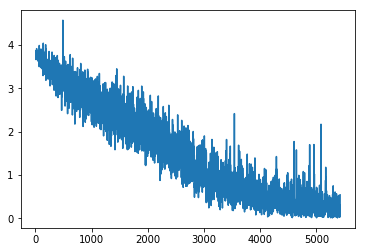

In [10]:
N=len(ArrI)
print(len(ArrI))
plt.plot(ArrI[5:N],ArrLoss[5:N])

## Save and load the Neural Network

In [11]:
torch.save(model.state_dict(), "../../modelParameters/C3N_Model.pth")

In [5]:
model.load_state_dict(torch.load("../../modelParameters/C3N_Model.pth"))
model.eval()

Net(
  (conv1): Conv3d(3, 30, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv2): Conv3d(30, 60, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv3): Conv3d(60, 100, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv4): Conv3d(100, 100, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (conv5): Conv3d(100, 100, kernel_size=(3, 5, 5), stride=(1, 1, 1), padding=(2, 2, 2))
  (mp222): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mp122): MaxPool3d(kernel_size=(1, 2, 2), stride=(1, 2, 2), padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=4000, out_features=2000, bias=True)
  (fc2): Linear(in_features=2000, out_features=100, bias=True)
  (fc3): Linear(in_features=100, out_features=46, bias=True)
)

In [6]:
def indexToLabel(labl):
    with open('labesIdx.csv') as csvfile:
        spamreader = csv.reader(csvfile)
        for row in spamreader:
            if (labl==int(row[1])):
                Words = row[0].split("/")
                print(Words[-1])
            

## Test the Neural Network 

Only one result in order to test to random images-videos

Result of Neural Network -> Ground Truth

In [7]:
def testOneImage(mn_dataset_loader):
    for vid, labels in mn_dataset_loader:
        

        #-----------------One of the Images--------------------
        images = vid[0,:,:,:,:]
        imgShow = images[0,0,:,:]
        plt.imshow(imgShow,cmap='gray')
        #------------------------------------------------------
        
        
        vid = vid.type('torch.FloatTensor')
        vid, labels = vid.to(device), labels.to(device) # With this way we transfer all the arrays to the GPU in order to make the processes there 
        

        output = model(vid)
        output = output.cpu()
        k = output.detach().numpy()
        k.shape=(46,1)
        mk = k.tolist()

        
        print("Result of Neural Network -> Ground Truth")
        idx=np.argmax(k)
        indexToLabel(idx)
        print(torch.max(output,1))


        indexToLabel(labels[0])
        print(mk[labels[0]],labels[0])

        t = np.arange(46)
        mt = t.tolist()
        
        plt.figure()
        plt.plot(mt,mk)


        break


No handlers could be found for logger "libav.h264"
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


Result of Neural Network -> Ground Truth
Tornado
(tensor(1.00000e-03 *
       [-5.7449]), tensor([ 40]))
Tornado
([-0.00574493408203125], tensor(40, device='cuda:0'))


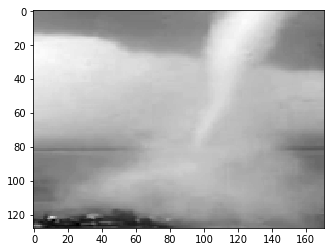

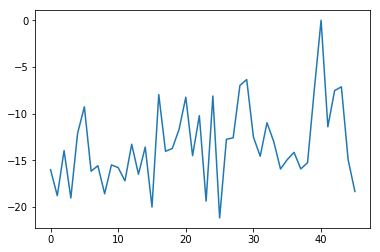

In [8]:
#----------------------------Data Loader------------------------
custom_mnist_from_csv = my2_classes.customDatasetVideos('videoPath_labels.csv',frameStart=5,frames=15,startH=30,startW=30,heightVid=128,widthVid=171)


mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=1, shuffle=True, num_workers = 1)
#---------------------------------------------------------------

testOneImage(mn_dataset_loader)

## Persentage of correct Images on Test Set

In [13]:
def persentageCorrectPredictions(mn_dataset_loader):
    allResults=0
    correctResults=0

    for vid, labels in mn_dataset_loader:

        vid = vid.type('torch.FloatTensor')
        vid, labels = vid.to(device), labels.to(device) # With this way we transfer all the arrays to the GPU in order to make the processes there 
        
        
        output = model(vid)
        output = output.cpu()
        k = output.detach().numpy()

    
        idx=np.argmax(k)
        allResults+=1
        if (idx == int(labels[0])):
            correctResults+=1

        pers = (float(correctResults)/float(allResults))*100
        print(allResults,correctResults,pers)

In [ ]:
#----------------------------Data Loader------------------------
custom_mnist_from_csv = my2_classes.customDatasetVideos('videoPath_LebelsTEST.csv',frameStart=5,frames=15,startH=30,startW=30,heightVid=128,widthVid=171)


mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=1, shuffle=True, num_workers = 7)
#---------------------------------------------------------------

persentageCorrectPredictions(mn_dataset_loader)

No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


(1, 0, 0.0)
(2, 0, 0.0)
(3, 0, 0.0)
(4, 1, 25.0)
(5, 1, 20.0)
(6, 2, 33.33333333333333)
(7, 3, 42.857142857142854)
(8, 4, 50.0)
(9, 5, 55.55555555555556)
(10, 6, 60.0)
(11, 6, 54.54545454545454)
(12, 7, 58.333333333333336)
(13, 7, 53.84615384615385)
(14, 7, 50.0)
(15, 7, 46.666666666666664)
(16, 8, 50.0)
(17, 8, 47.05882352941176)
(18, 8, 44.44444444444444)
(19, 8, 42.10526315789473)
(20, 8, 40.0)
(21, 8, 38.095238095238095)
(22, 9, 40.909090909090914)
(23, 9, 39.130434782608695)
(24, 10, 41.66666666666667)
(25, 11, 44.0)
(26, 12, 46.15384615384615)
(27, 12, 44.44444444444444)
(28, 13, 46.42857142857143)
(29, 13, 44.827586206896555)
(30, 14, 46.666666666666664)
(31, 14, 45.16129032258064)
(32, 14, 43.75)
(33, 14, 42.42424242424242)
(34, 14, 41.17647058823529)
(35, 14, 40.0)
(36, 15, 41.66666666666667)
(37, 15, 40.54054054054054)
(38, 16, 42.10526315789473)
(39, 16, 41.02564102564102)
(40, 16, 40.0)
(41, 16, 39.02439024390244)
(42, 17, 40.476190476190474)
(43, 18, 41.86046511627907)
(44

(301, 139, 46.179401993355484)
(302, 139, 46.026490066225165)
(303, 139, 45.87458745874587)
(304, 139, 45.723684210526315)
(305, 139, 45.57377049180328)
(306, 139, 45.42483660130719)
(307, 140, 45.60260586319218)
(308, 140, 45.45454545454545)
(309, 140, 45.307443365695796)
(310, 140, 45.16129032258064)
(311, 140, 45.01607717041801)
(312, 141, 45.19230769230769)
(313, 141, 45.04792332268371)
(314, 142, 45.22292993630573)
(315, 143, 45.3968253968254)
(316, 144, 45.56962025316456)
(317, 144, 45.42586750788644)
(318, 145, 45.59748427672956)
(319, 145, 45.45454545454545)
(320, 145, 45.3125)
(321, 146, 45.482866043613704)
(322, 146, 45.3416149068323)
(323, 147, 45.51083591331269)
(324, 148, 45.67901234567901)
(325, 148, 45.53846153846154)
(326, 148, 45.39877300613497)
(327, 149, 45.56574923547401)
(328, 150, 45.73170731707317)
(329, 151, 45.8966565349544)
(330, 152, 46.06060606060606)
(331, 152, 45.9214501510574)
(332, 152, 45.78313253012048)
(333, 152, 45.645645645645644)
(334, 153, 45.8083

Process Process-328:
Process Process-330:
Traceback (most recent call last):
Process Process-326:
Process Process-329:
Traceback (most recent call last):
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Process Process-327:
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-325:
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
Traceback (most recent call last):
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap


(448, 203, 45.3125)
(449, 204, 45.43429844097995)
(450, 205, 45.55555555555556)
(451, 205, 45.45454545454545)
(452, 206, 45.57522123893805)
(453, 207, 45.6953642384106)
(454, 208, 45.81497797356828)
(455, 209, 45.934065934065934)


    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
    self.run()
Process Process-331:
    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 114, in run
    self._target(*self._args, **self._kwargs)
    self.run()
    self.run()
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 114, in run
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 114, in run
Traceback (most recent call last):
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pyto

KeyboardInterrupt: 

    self._target(*self._args, **self._kwargs)
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/process.py", line 267, in _bootstrap
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
    r = index_queue.get()
    self._target(*self._args, **self._kwargs)
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/torch/utils/data/dataloader.py", line 57, in _worker_loop
  File "/mnt/storage/home/qb18517/qb18517/.conda/envs/pytorch/lib/python2.7/multiprocessing/queues.py", line 376, in get
  File "/mnt/storage/home/qb18517/qb1851

## Confusion Matrix

In [9]:
def convfusionMatrixF(mn_dataset_loader,dataChecked):
    
    
    widgets = ['Test: ', Percentage(), ' ', Bar(marker='0',left='[',right=']'),
           ' ', ETA(), ' ', FileTransferSpeed()] #For the processBar
    pbar = ProgressBar(widgets=widgets, maxval=dataChecked)
    pbar.start()
    LabelsCount=45
    
    
    
    ConfusionMatrix = np.zeros((LabelsCount,LabelsCount))
    i=0
    for vid, labels in mn_dataset_loader:

        vid = vid.type('torch.FloatTensor')
        vid, labels = vid.to(device), labels.to(device) # With this way we transfer all the arrays to the GPU in order to make the processes there 
        
        
        output = model(vid)
        output = output.cpu()
        k = output.detach().numpy()
        idx=np.argmax(k)
        actualValue=int(labels[0])

        
        ConfusionMatrix[idx,actualValue]+=1

    
        #---------------Next Interation--------------------
        i+=1  
        if (i>dataChecked):
            break   
        pbar.update(i)
        #--------------------------------------------------

        
    #----------------Normalize the Confusion Matrix-----------------
#     sumRow = ConfusionMatrix.sum(axis=1)
#     sumRow = sumRow.reshape(LabelsCount,1)    
#     ConfusionMatrix = np.divide(ConfusionMatrix,sumRow)
    #---------------------------------------------------------------
    
        
    return ConfusionMatrix

    


No handlers could be found for logger "libav.h264" ] ETA:  --:--:--   0.00  B/s
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
No handlers could be found for logger "libav.h264"
/mnt/storage/scratch/qb18517/.conda/envs/pytorch/lib/python2.7/site-packages/ipykernel_launcher.py:54: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Exception NameError: "global name 'FileNotFoundError' is not defined" in <bound method _DataLoaderIter.__del__ of <torch.utils.data.dataloader._DataLoaderIter object at 0x2b7c90f15ed0>> ignored


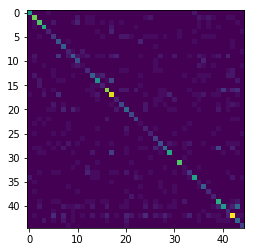

In [11]:
#----------------------------Data Loader------------------------
custom_mnist_from_csv = my2_classes.customDatasetVideos('videoPath_LebelsTEST.csv',frameStart=5,frames=15,startH=30,startW=30,heightVid=128,widthVid=171)

mn_dataset_loader = torch.utils.data.DataLoader(dataset=custom_mnist_from_csv,
                                                    batch_size=1, shuffle=True, num_workers = 10)
#---------------------------------------------------------------

ConfusionMatrix=convfusionMatrixF(mn_dataset_loader,1000)

plt.imshow(ConfusionMatrix)

In [22]:
print(ConfusionMatrix[24,:])

for i in range(45):
    print(ConfusionMatrix[i,i])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
20.0
33.0
23.0
19.0
3.0
1.0
9.0
4.0
0.0
10.0
9.0
1.0
1.0
7.0
9.0
4.0
10.0
34.0
2.0
5.0
4.0
2.0
8.0
2.0
0.0
2.0
6.0
0.0
13.0
15.0
0.0
18.0
2.0
3.0
14.0
2.0
7.0
3.0
0.0
1.0
16.0
6.0
18.0
12.0
0.0
